# Rank Abundance Curves

### Importing CNN-Classified IFCB Data

1. dfc is named concentration_by_class_time_series_CNN_daily08Sep2021.csv. It contains the date, mL analyzed, and the concentrations of all IFCB categories which are mostly species.

2. cl is named IFCB_classlist_type.csv and specifies which categories correspond to a functional group.

In [7]:
library("dplyr");
library("tidyr");
library("ggplot2");
library("lubridate");
library("ggrepel");
library("data.table");
library("zoo");
library("scales");
library("codyn");
library("viridis"); #for color palettes

# install.packages("hash")
library("hash"); #so you can make that month dictionary for dates 

basepath = "/D/MIT-WHOI/github_repos/plankton-index/"
dfc = read.csv(paste0(basepath,'data/count_by_class_time_seriesCNN_hourly08Sep2021.csv')) #hourly count of plankton
cl =  read.csv(paste0(basepath,'/data/IFCB_classlist_type.csv'))

# head(dfc)
# head(cl)

names(cl)
mapf <- function(Fgroup){
    which(colnames(dfc) %in% cl[cl[Fgroup] == 1,]$CNN_classlist)} #generates list of species within the specified functional grou

#removing categories within the Other.not.alive and the IFCB.artifact groups from dfc
dfc <- dfc %>%  na.omit(dfc) %>% select(-c(mapf("Other.not.alive"),mapf("IFCB.artifact"),mix))

#extracting dates and creating columns for individual date values
dfc$datetime = as.Date(dfc$datetime, format = "%d-%b-%Y %H:%M:%S")
dfc$totalcount = rowSums(subset(dfc, select=Acanthoica_quattrospina:zooplankton))
dfc$year = year(dfc$date)
dfc$month = sprintf("%02d",month(dfc$date))
dfc$day =  sprintf("%02d",day(dfc$date))
dfc$my = paste0(dfc$year,"_",dfc$month)
dfc$week = week(dfc$date)
dfc$wy = paste0(dfc$year,"_",dfc$week)

#grouping at the week of the year
dfc.wy <- dfc%>% group_by(wy)%>% mutate_at(vars(Acanthoica_quattrospina:totalcount),sum) %>% distinct(wy,.keep_all = TRUE)

# head(dfc.wy)
df_to_rac = dfc.wy[order(dfc.wy$datetime),]

#making copies of df_to_rac
df.rank = data.frame(df_to_rac)
df.rel.abund = data.frame(df_to_rac)

[1] "CNN_classlist"   "Diatom"          "pennatediatom"   "Dinoflagellate" 
 [5] "Coccolithophore" "Ciliate"         "flagellate"      "Nano"           
 [9] "Other.live"      "Other.not.alive" "IFCB.artifact"

### QC for IFCB counts

In [8]:
head(dfc)

,datetime,milliliters_analyzed,Acanthoica_quattrospina,Akashiwo,Alexandrium_catenella,Amphidinium,Amylax,Apedinella,Asterionellopsis_glacialis,Bacillaria,⋯,square_unknown,unknown2,zooplankton,totalcount,year,month,day,my,week,wy
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,2006-06-06,4.063245,0,0,0,0,0,0,1,0,⋯,0,0,0,407,2006,06,06,2006_06,23,2006_23
2,2006-06-06,4.337958,0,0,0,0,0,0,0,0,⋯,0,0,0,528,2006,06,06,2006_06,23,2006_23
3,2006-06-06,13.199159,0,0,0,0,0,0,1,0,⋯,0,0,0,1335,2006,06,06,2006_06,23,2006_23
4,2006-06-06,8.019507,0,0,0,0,0,0,1,0,⋯,0,0,0,820,2006,06,06,2006_06,23,2006_23
5,2006-06-06,14.931327,1,0,0,0,0,3,0,0,⋯,0,0,1,1588,2006,06,06,2006_06,23,2006_23
6,2006-06-06,8.713200,0,0,0,0,0,3,0,0,⋯,0,0,0,1050,2006,06,06,2006_06,23,2006_23


,id,flag
,<fct>,<int>
1,D20181008T214137_IFCB109,1
2,D20181008T220407_IFCB109,1
3,D20181008T222637_IFCB109,1
4,D20181031T201422_IFCB010,1
5,D20181031T203656_IFCB010,1
6,D20181120T194146_IFCB010,1


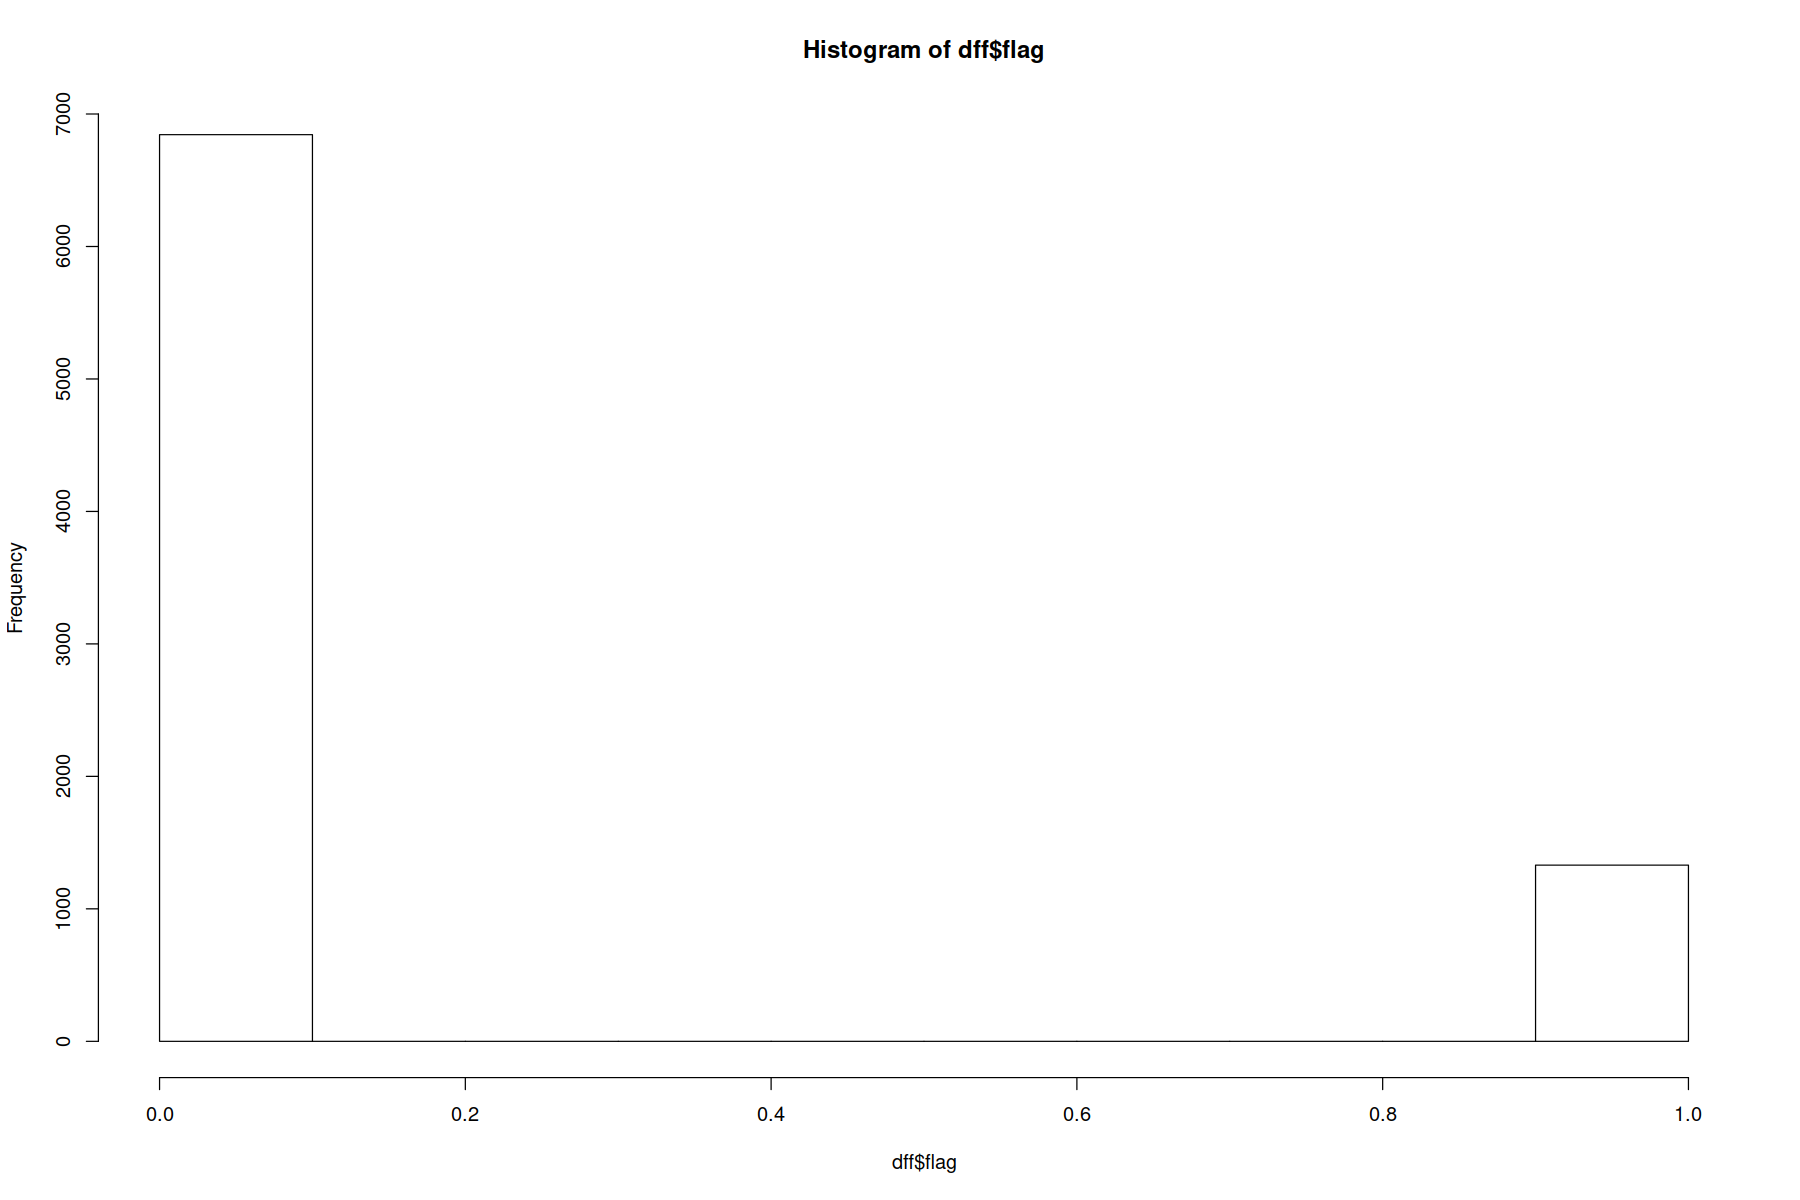


## plotting species richness 

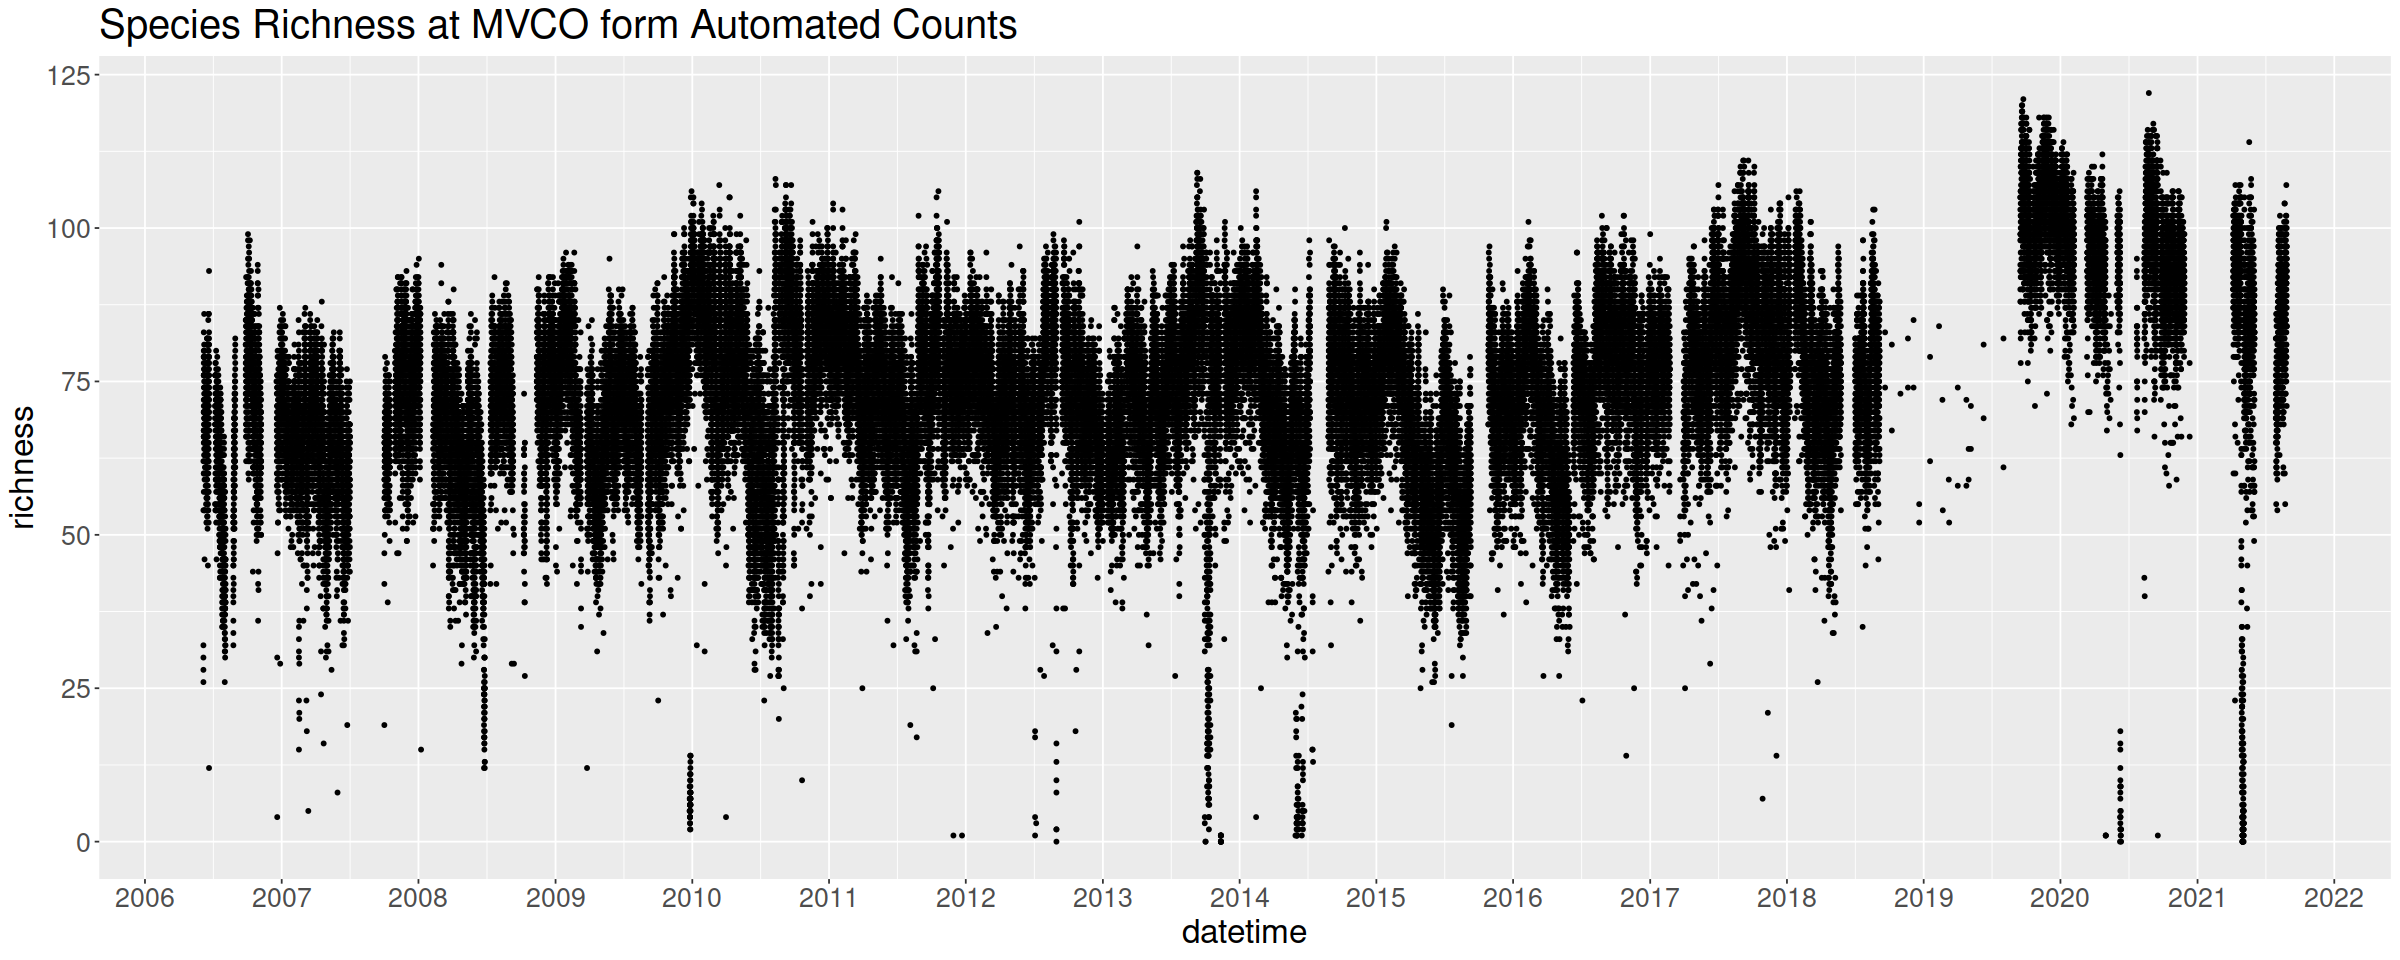

In [9]:
dfc$richness <- rowSums(dfc[,which(colnames(dfc)=="Acanthoica_quattrospina"):which(colnames(dfc) == "zooplankton")] != 0)

options(repr.plot.width=20, repr.plot.height=8)

ggplot(data=dfc, aes(x = datetime, y = richness)) +geom_point(size = 1)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))+
    theme(text = element_text(size = 20))+
    ggtitle("Species Richness at MVCO form Automated Counts")

Warning message:
“Removed 1 rows containing missing values (geom_point).”


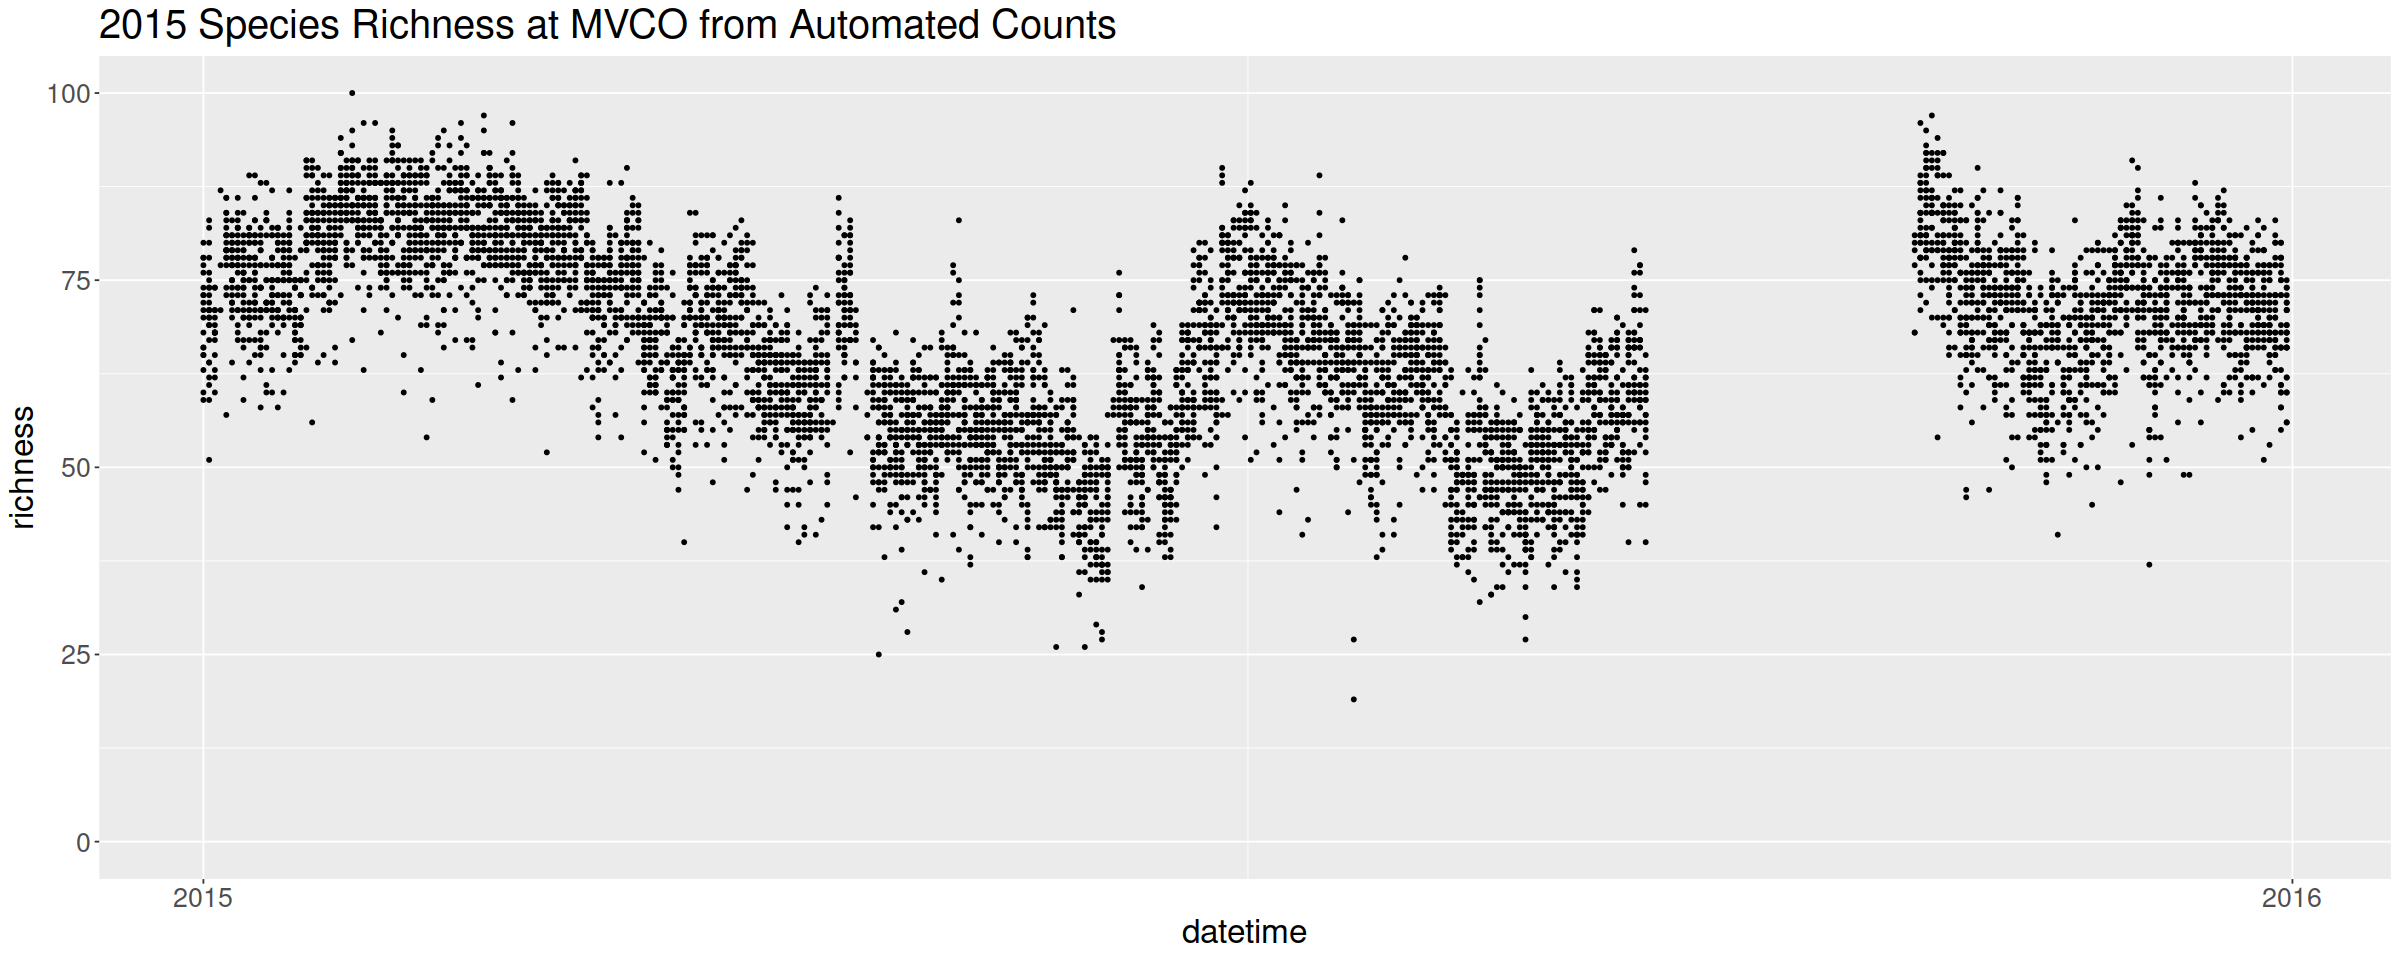

In [10]:

options(repr.plot.width=20, repr.plot.height=8)
plt.year = 2015
ggplot(data=dfc %>% filter(year == plt.year), aes(x = datetime, y = richness)) +geom_point(size = 1)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))+
    theme(text = element_text(size = 20))+
    ggtitle(paste(plt.year,"Species Richness at MVCO from Automated Counts"))+
    ylim(c(0,100))

### populate df.rank and df.rel.abund

In [11]:
ii = 1
max_rank = 20
# for testing out a couple RAC curves
counts=as.data.frame(t(subset(df_to_rac, select=Acanthoica_quattrospina:zooplankton)[ii,])) #extracts vector of counts of each category at a given row
colnames(counts) <- "count" #rename 1st column to count
counts$species <- rownames(counts) #make rownames a column in the dataframe
rownames(counts) <- NULL #remove rownames

ii.sort = order(counts$count,decreasing = TRUE)

#adding column for the relative rank of each species
counts$rank <- NA
counts$rank[ii.sort] <- 1:nrow(counts)

counts <- counts %>% mutate(rel.abund = count/sum(count))

# #amend rank and relative abundance matricies with ranks and relative abundances
df.rank[ii,which(colnames(df.rel.abund)=="Acanthoica_quattrospina"):which(colnames(df.rel.abund) == "zooplankton")] <- as.list(counts$rank)
df.rel.abund[ii,which(colnames(df.rel.abund)=="Acanthoica_quattrospina"):which(colnames(df.rel.abund) == "zooplankton")] <- as.list(counts$rel.abund)


#populate df.rank and df.rel.abund
for(ii in seq(1,length(df_to_rac$datetime),1)){
    max_rank = 20
    # for testing out a couple RAC curves
    counts=as.data.frame(t(subset(df_to_rac, select=Acanthoica_quattrospina:zooplankton)[ii,])) #extracts vector of counts of each category at a given row
    colnames(counts) <- "count" #rename 1st column to count
    counts$species <- rownames(counts) #make rownames a column in the dataframe
    rownames(counts) <- NULL #remove rownames

    ii.sort = order(counts$count,decreasing = TRUE)

    #adding column for the relative rank of each species
    counts$rank <- NA
    counts$rank[ii.sort] <- 1:nrow(counts)
    counts <- counts %>% mutate(rel.abund = count/sum(count))
    
    #amend rank and relative abundance matricies with ranks and relative abundances
    df.rank[ii,which(colnames(df.rel.abund)=="Acanthoica_quattrospina"):which(colnames(df.rel.abund) == "zooplankton")] <- as.list(counts$rank)
    df.rel.abund[ii,which(colnames(df.rel.abund)=="Acanthoica_quattrospina"):which(colnames(df.rel.abund) == "zooplankton")] <- as.list(counts$rel.abund)
}

print("populated")


[1] "populated"


### printing plot of rank abundance curves


Warning message:
“Removed 96 rows containing missing values (geom_point).”
Warning message:
“Removed 96 row(s) containing missing values (geom_path).”


[1] "/D/MIT-WHOI/github_repos/plankton-index//results/weekly_rac/racplot_2021-08-26_673.png"


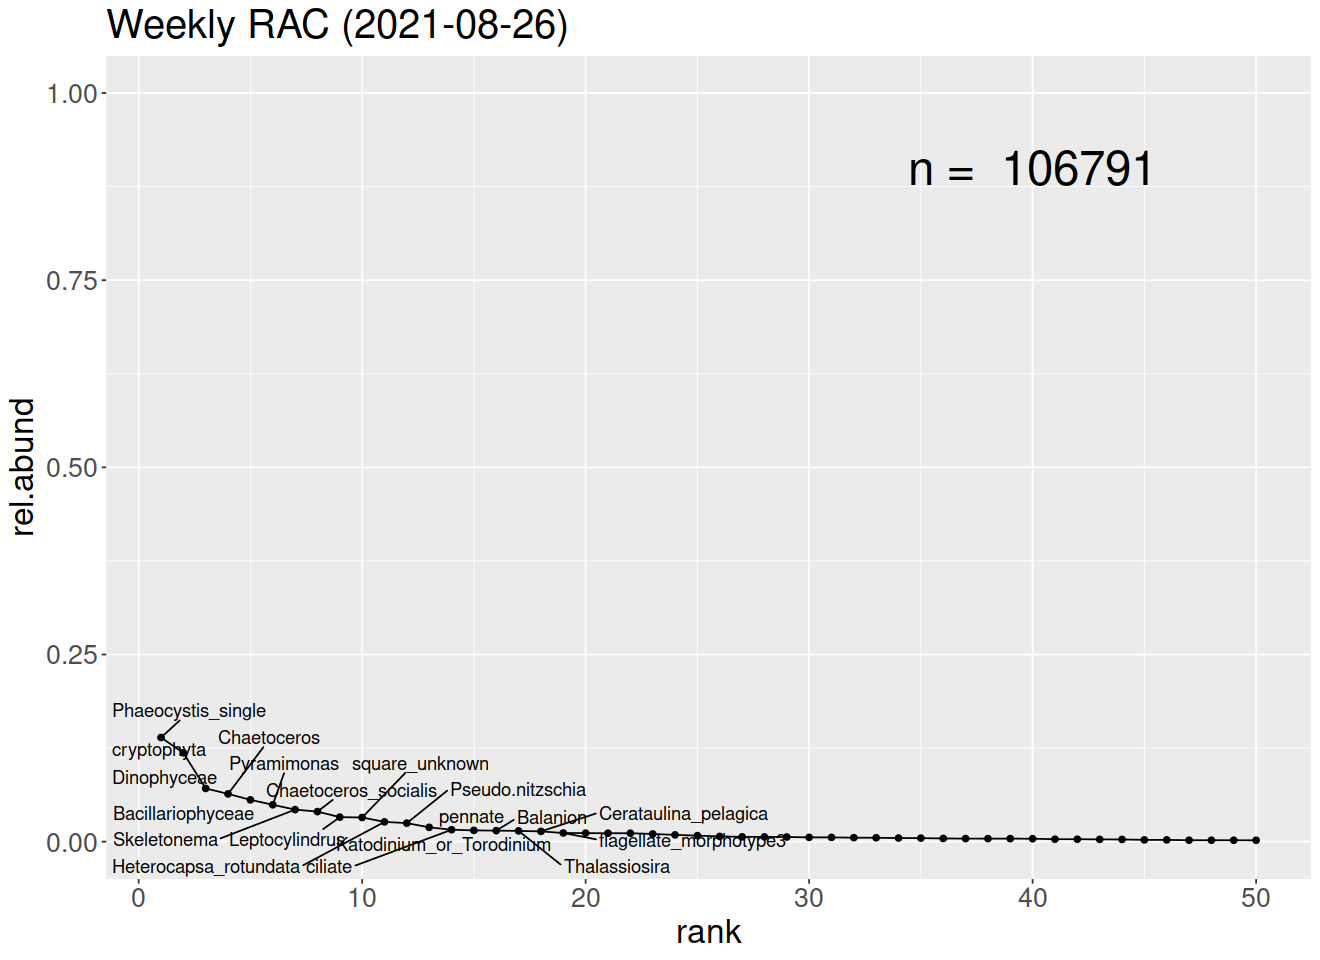

In [12]:
# PLOTTING
options(repr.plot.width=11, repr.plot.height=8)

print(ggplot(counts,aes(x = rank,y = rel.abund, label = species)) +
  xlim(1,50)+ylim(0,1)+
      geom_point()+
      geom_line()+
      geom_text_repel(data = subset(counts, rank < max_rank, nudge_x = 0.1 ))+
      annotate("text", x = 40,y=0.9,size = 10,label = paste("n = ",df_to_rac$totalcount[ii]))+
     ggtitle(paste0("Weekly RAC (",df_to_rac$datetime[ii],")"))+
theme(text = element_text(size = 20)))
result_path = paste0(basepath,"/results/weekly_rac/")
print(paste0(result_path,"racplot_",df_to_rac$datetime[ii],"_",sprintf("%03d", ii),".png"))


In [13]:
#converting to long format
df.rank.long <- pivot_longer(df.rank,Acanthoica_quattrospina:zooplankton,names_to = "species",values_to ="rank",values_drop_na=FALSE)
df.rel.abund.long <- pivot_longer(df.rel.abund,Acanthoica_quattrospina:zooplankton,names_to = "species",values_to ="rel.abund",values_drop_na=FALSE)

nrow(df.rank.long)
nrow(df.rel.abund.long)

df.rank.long$rel.abund <- df.rel.abund.long$rel.abund

# df.rank.long$month <- as.(df.rank.long$month)
head(df.rank.long)


[1] 98258

[1] 98258

datetime,milliliters_analyzed,totalcount,year,month,day,my,week,wy,species,rank,rel.abund
<date>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Acanthoica_quattrospina,34,1.687672e-03
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Akashiwo,126,5.192836e-06
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Alexandrium_catenella,105,3.115702e-05
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Amphidinium,101,4.154269e-05
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Amylax,107,2.596418e-05
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Apedinella,39,1.189159e-03


### Plotting Rank Abundance Curves Stacked

Warning message:
“Removed 91528 rows containing missing values (geom_point).”
Warning message:
“Removed 91528 row(s) containing missing values (geom_path).”


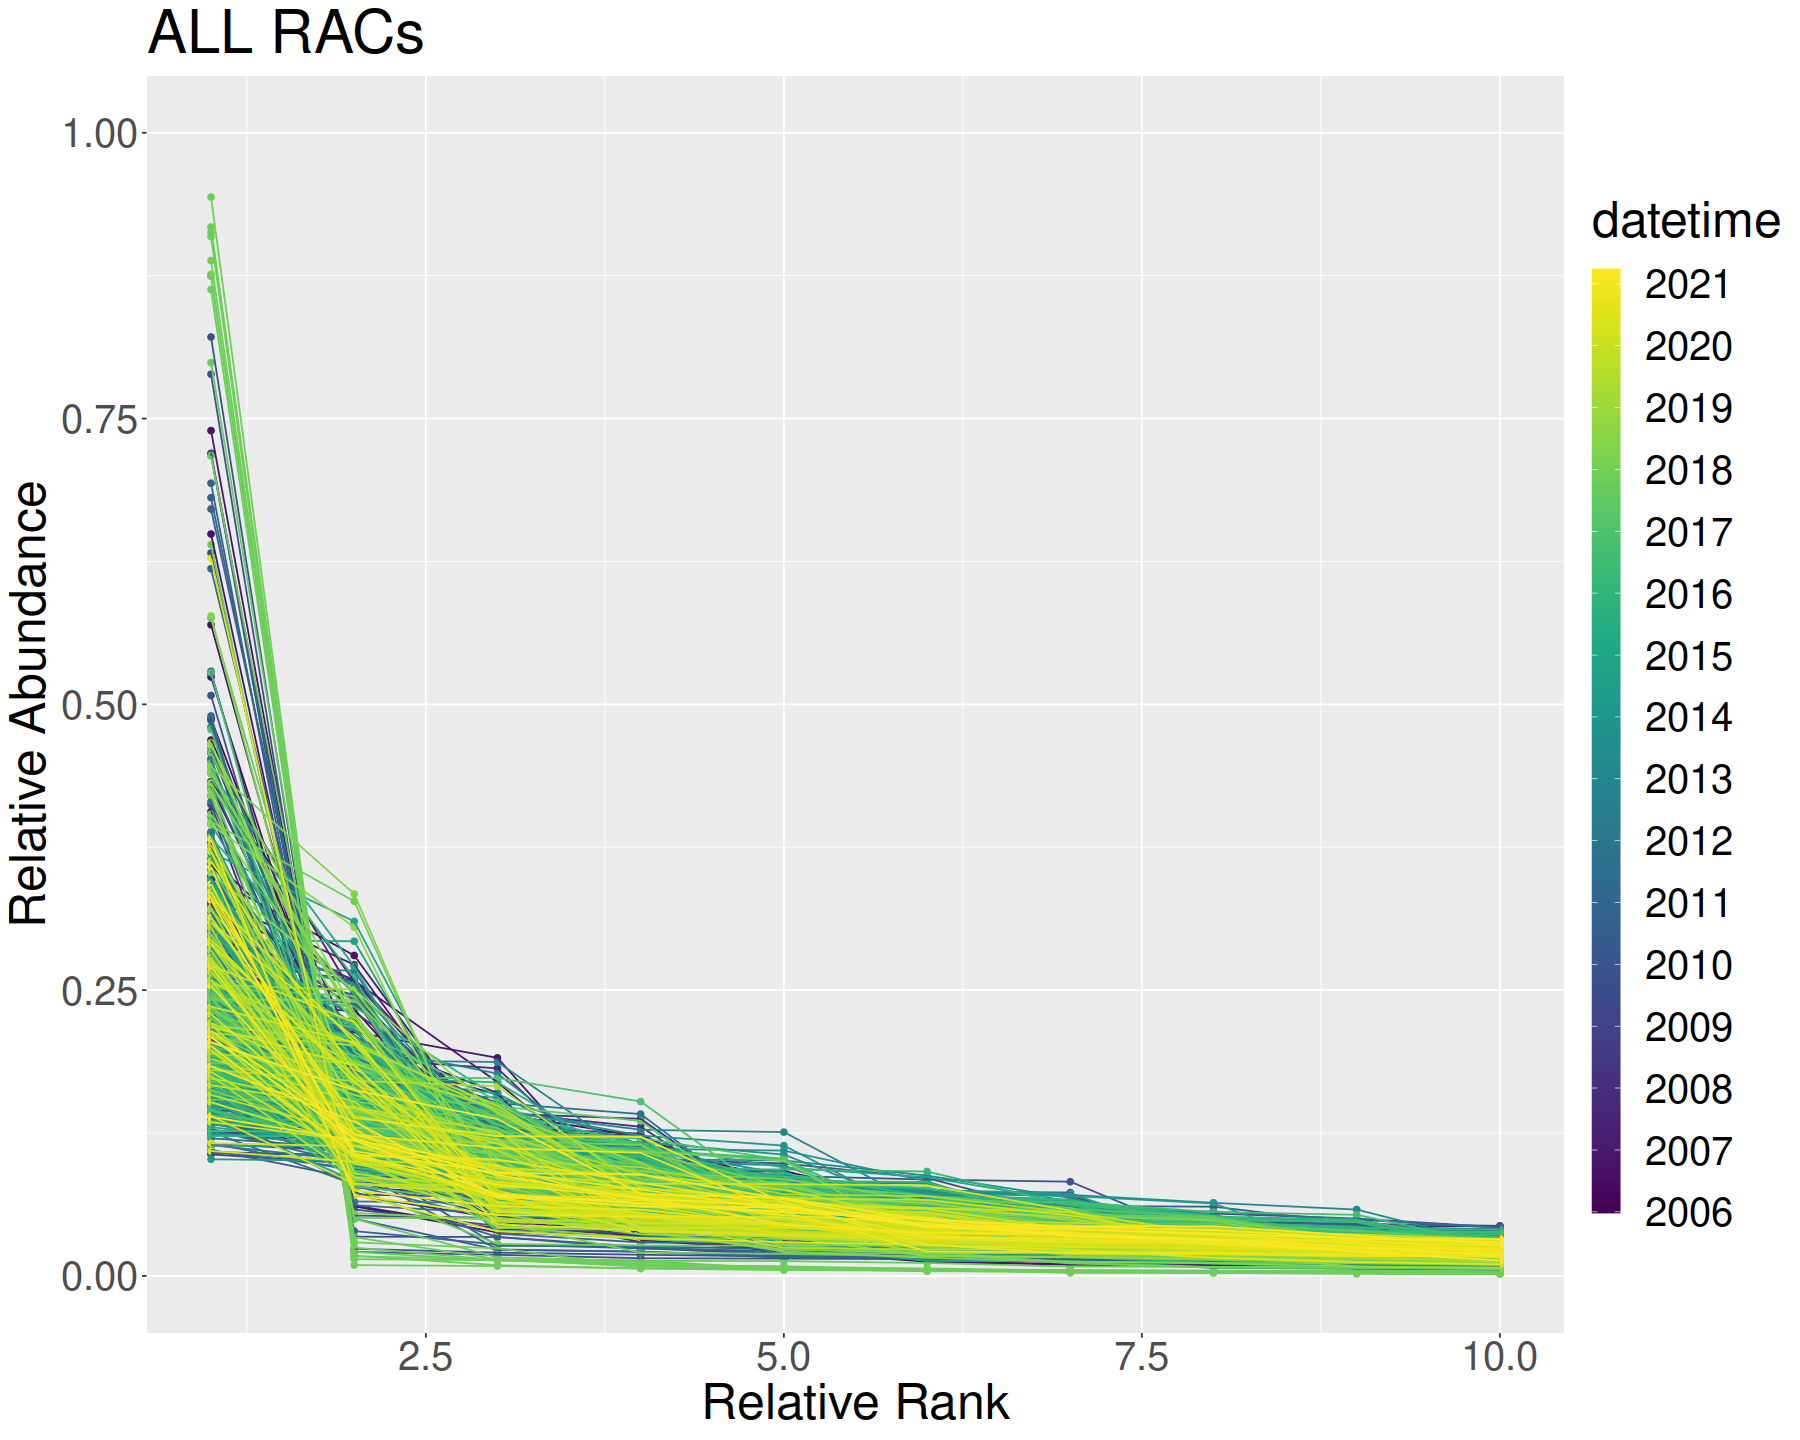

In [14]:
options(repr.plot.width=15, repr.plot.height=12)
library("viridis")
brk <- seq.Date(min(df.rank.long$datetime), max(df.rank.long$datetime), by = "1 year")


df.rank.long %>%
  ggplot( aes(x=rank, y=rel.abund, group=datetime, color=datetime)) +
    geom_point()+
    geom_line()+
    xlim(1,10)+ylim(0,1)+
    theme(text = element_text(size = 30), legend.key.height = unit(4, "cm"))+
    xlab("Relative Rank")+
    ylab("Relative Abundance")+
      scale_color_viridis(trans = "date",
                           breaks = brk,
                      labels = format(brk, "%Y"))+
    ggtitle("ALL RACs")


### Plotting by Month

In [41]:
typeof(df.rank.long$month)
unique(df.rank.long$month)

[1] "character"

[1] "06" "07" "08" "09" "10" "11" "12" "01" "02" "03" "04" "05"

In [15]:

options(repr.plot.width=15, repr.plot.height=20)
brk <- seq.Date(min(df.rank.long$datetime), max(df.rank.long$datetime), by = "1 year")

max_rank = 2
result_path = "/D/MIT-WHOI/github_repos/plankton-index/results/month_rac/"
for(plt.month in unique(df.rank.long$month)){
    df.rank.long %>% filter(month == plt.month) %>%
      ggplot( aes(x=rank, y=rel.abund, group=datetime, color=datetime,label = species)) +
        geom_point(size = 2)+
        geom_line(size = 1.5)+
        xlim(1,5)+ylim(0,1)+
        theme(text = element_text(size = 30), legend.key.height = unit(4, "cm"))+
        geom_text_repel(data = subset(filter(df.rank.long,month == plt.month), rank < max_rank, nudge_x = 0.1 ))+
        xlab("Relative Rank")+
        ylab("Relative Abundance")+
          scale_color_viridis(trans = "date",
                               breaks = brk,
                          labels = format(brk, "%Y"))+
        ggtitle(paste0("RACs during ",plt.month))+
        ggsave(paste0(result_path,"racplot_month_",plt.month,".png"),width = 10,height =8,units = "in",dpi = 500)
};
print("finished saving plots")

Warning message:
“Removed 7191 rows containing missing values (geom_point).”
Warning message:
“Removed 7191 row(s) containing missing values (geom_path).”
Warning message:
“Removed 8178 rows containing missing values (geom_point).”
Warning message:
“Removed 8178 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6909 rows containing missing values (geom_point).”
Warning message:
“Removed 6909 row(s) containing missing values (geom_path).”
Warning message:
“Removed 7755 rows containing missing values (geom_point).”
Warning message:
“Removed 7755 row(s) containing missing values (geom_path).”
Warning message:
“Removed 7332 rows containing missing values (geom_point).”
Warning message:
“Removed 7332 row(s) containing missing values (geom_path).”
Warning message:
“Removed 7614 rows containing missing values (geom_point).”
Warning message:
“Removed 7614 row(s) containing missing values (geom_path).”
Warning message:
“Removed 9306 rows containing missing values (geom_po

[1] "finished saving plots"


## Plotting by Year

In [45]:
options(repr.plot.width=15, repr.plot.height=20)
brk <- seq.Date(min(df.rank.long$datetime), max(df.rank.long$datetime), by = "1 month")

result_path = "/D/MIT-WHOI/github_repos/plankton-index/results/yearly_rac/"
for(plt.year in unique(df.rank.long$year)){
df.rank.long %>% filter(year == plt.year) %>%
  ggplot( aes(x=rank, y=rel.abund, group=datetime, color=datetime, label = species)) +
    geom_point(size = 2)+
    geom_line(size = 1.5)+
    xlim(1,5)+ylim(0,1)+
    theme(text = element_text(size = 15), legend.key.height = unit(2, "cm"))+
    xlab("Relative Rank")+
    ylab("Relative Abundance")+
      scale_color_viridis(trans = "date",
                           breaks = brk,
                      labels = format(brk, "%m"),name = "Month")+
    ggtitle(paste0(plt.year," RACs"))+
    geom_text_repel(data = subset(filter(df.rank.long,year == plt.year), rank < max_rank, nudge_x = 0.1 ))
    ggsave(paste0(result_path,"racplot_year_",plt.year,".png"),dpi = 500)
};

print("finished saving plots")


Saving 6.67 x 6.67 in image

Warning message:
“Removed 2820 rows containing missing values (geom_point).”
Warning message:
“Removed 2820 row(s) containing missing values (geom_path).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 5640 rows containing missing values (geom_point).”
Warning message:
“Removed 5640 row(s) containing missing values (geom_path).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 5922 rows containing missing values (geom_point).”
Warning message:
“Removed 5922 row(s) containing missing values (geom_path).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 6909 rows containing missing values (geom_point).”
Warning message:
“Removed 6909 row(s) containing missing values (geom_path).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 7473 rows containing missing values (geom_point).”
Warning message:
“Removed 7473 row(s) containing missing values (geom_path).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 7473 rows containing miss

[1] "finished saving plots"


Warning message:
“Removed 9306 rows containing missing values (geom_point).”
Warning message:
“Removed 9306 row(s) containing missing values (geom_path).”


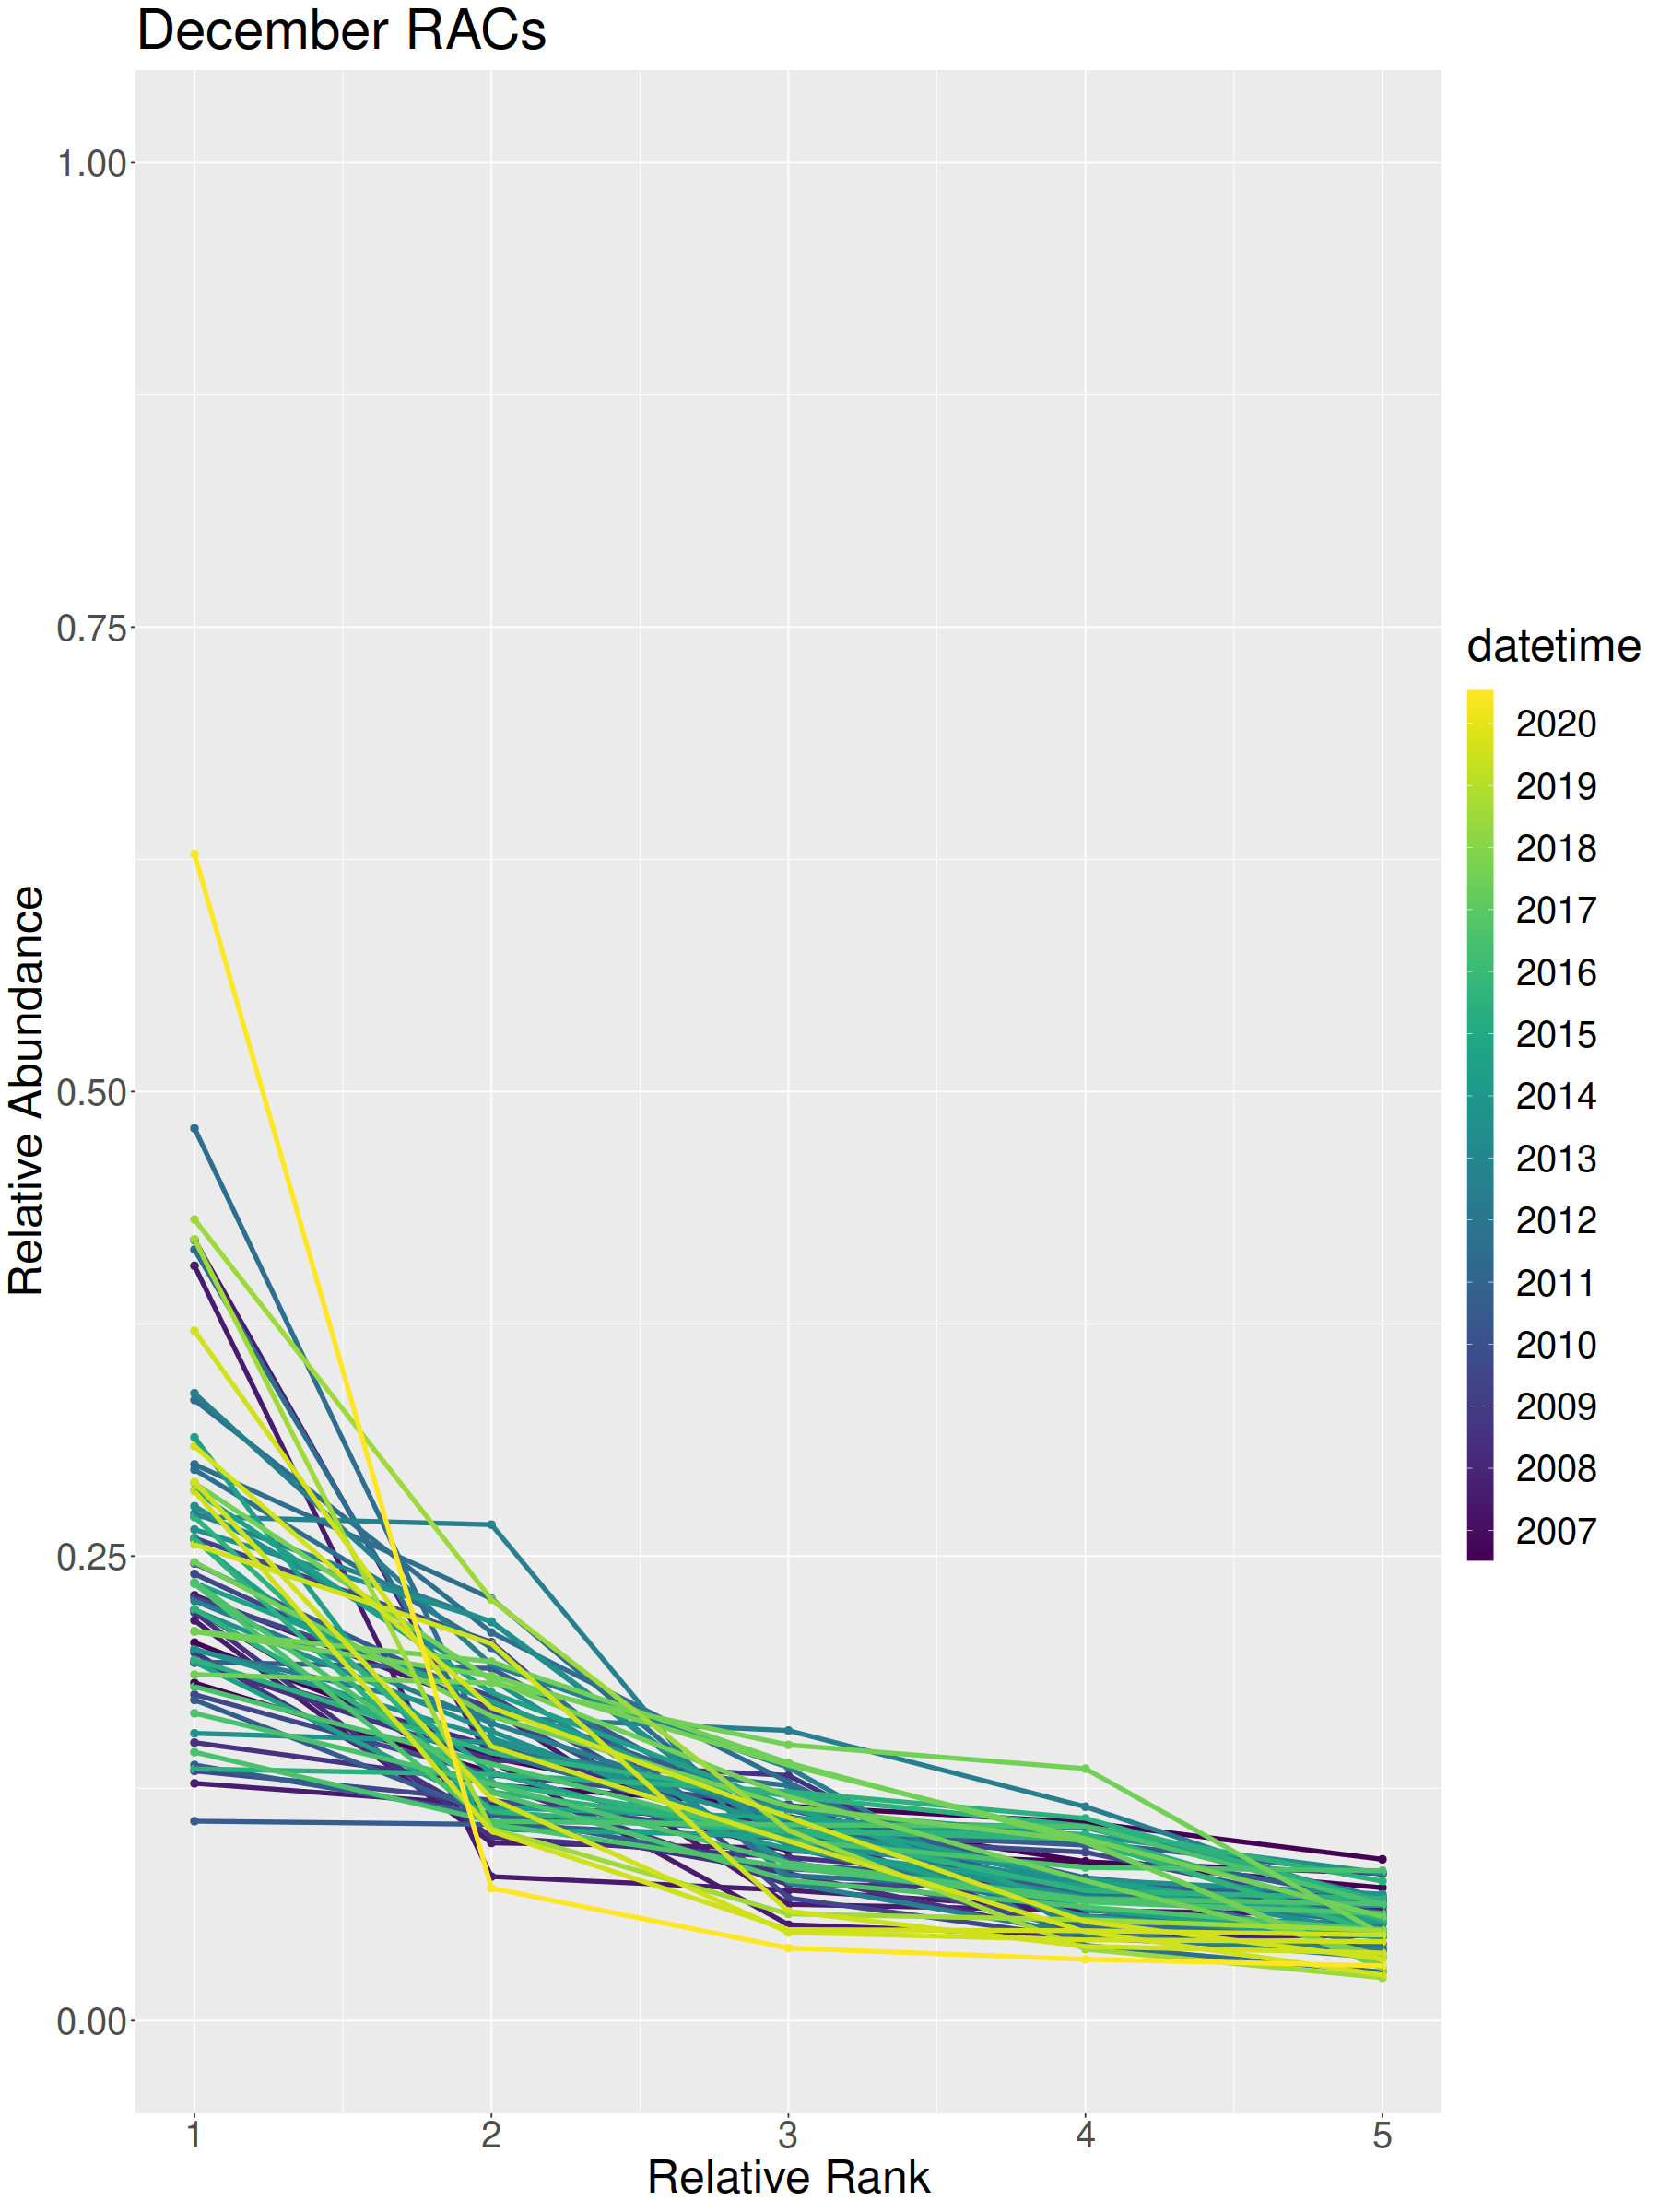

In [16]:
options(repr.plot.width=15, repr.plot.height=20)
brk <- seq.Date(min(df.rank.long$datetime), max(df.rank.long$datetime), by = "1 year")

df.rank.long %>% filter(month == "12") %>%
  ggplot( aes(x=rank, y=rel.abund, group=datetime, color=datetime)) +
    geom_point(size = 2)+
    geom_line(size = 1.5)+
    xlim(1,5)+ylim(0,1)+
    theme(text = element_text(size = 30), legend.key.height = unit(4, "cm"))+
    xlab("Relative Rank")+
    ylab("Relative Abundance")+
      scale_color_viridis(trans = "date",
                           breaks = brk,
                      labels = format(brk, "%Y"))+
    ggtitle(paste0("December RACs"))



In [48]:
head(dfc)

,datetime,milliliters_analyzed,Acanthoica_quattrospina,Akashiwo,Alexandrium_catenella,Amphidinium,Amylax,Apedinella,Asterionellopsis_glacialis,Bacillaria,⋯,unknown2,zooplankton,totalcount,year,month,day,my,week,wy,richness
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
1,2006-06-06,4.063245,0,0,0,0,0,0,1,0,⋯,0,0,407,2006,06,06,2006_06,23,2006_23,28
2,2006-06-06,4.337958,0,0,0,0,0,0,0,0,⋯,0,0,528,2006,06,06,2006_06,23,2006_23,30
3,2006-06-06,13.199159,0,0,0,0,0,0,1,0,⋯,0,0,1335,2006,06,06,2006_06,23,2006_23,32
4,2006-06-06,8.019507,0,0,0,0,0,0,1,0,⋯,0,0,820,2006,06,06,2006_06,23,2006_23,26
5,2006-06-06,14.931327,1,0,0,0,0,3,0,0,⋯,0,1,1588,2006,06,06,2006_06,23,2006_23,62
6,2006-06-06,8.713200,0,0,0,0,0,3,0,0,⋯,0,0,1050,2006,06,06,2006_06,23,2006_23,54


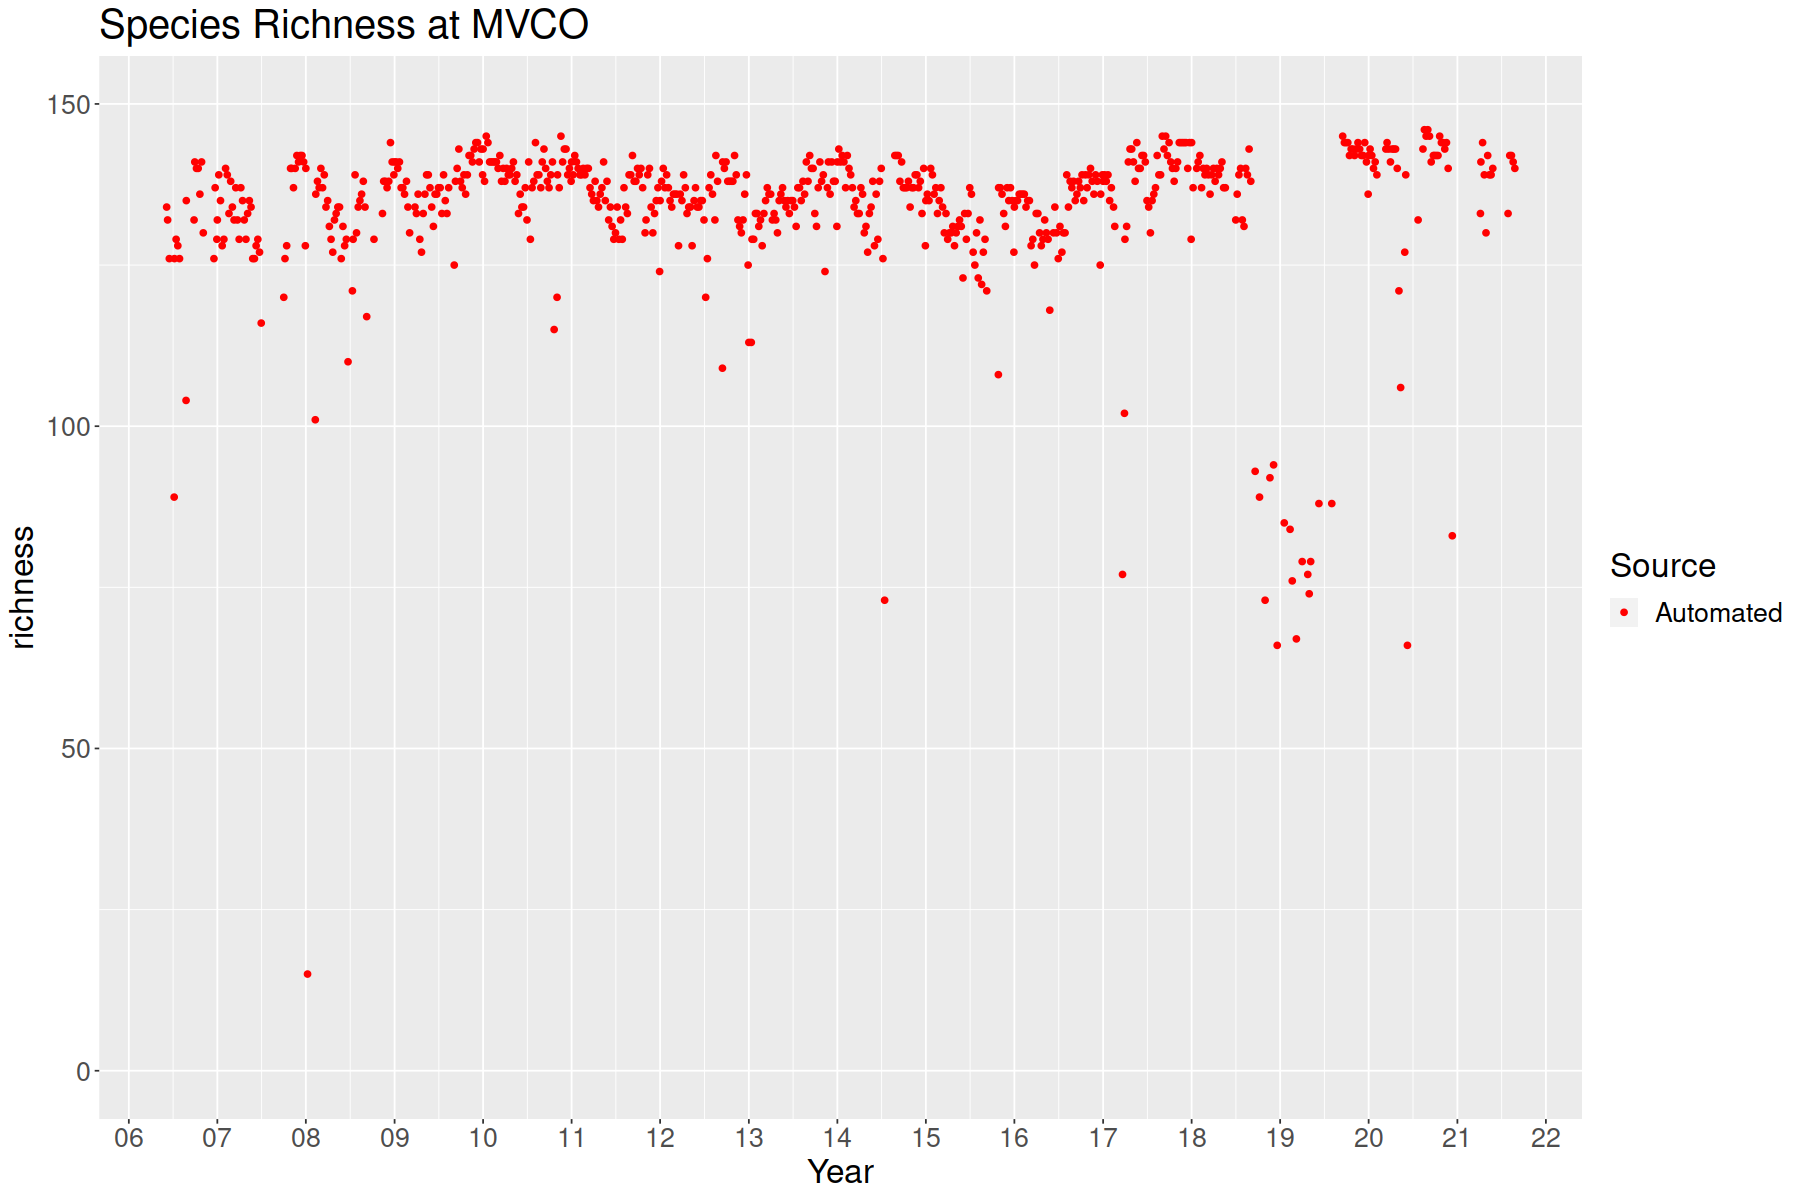

In [18]:
dfc.wy$richness <- rowSums(dfc.wy[,which(colnames(dfc.wy)=="Acanthoica_quattrospina"):which(colnames(dfc.wy) == "zooplankton")] != 0)
options(repr.plot.width=15, repr.plot.height=10)

ggplot() +
    geom_point(data = dfc.wy, aes(x = datetime,y = richness,color = "Automated"))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    theme(text = element_text(size = 20))+
    ggtitle("Species Richness at MVCO")+
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))+
    ylim(c(0,150))+
    xlab("Year")


In [ ]:
df

datetime,milliliters_analyzed,Acanthoica_quattrospina,Akashiwo,Alexandrium_catenella,Amphidinium,Amylax,Apedinella,Asterionellopsis_glacialis,Bacillaria,⋯,square_unknown,unknown2,zooplankton,totalcount,year,month,day,my,week,wy
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
2006-06-06,4.063245,34,126,105,101,107,39,54,120,⋯,44,79,100,100,2006,06,06,2006_06,23,2006_23
2006-06-10,10.573908,36,118,133,83,108,58,51,119,⋯,37,106,94,429135,2006,06,10,2006_06,24,2006_24
2006-06-17,9.768705,44,127,128,81,93,63,47,129,⋯,32,104,116,333279,2006,06,17,2006_06,25,2006_25
2006-07-07,9.818548,40,90,91,92,72,54,37,93,⋯,35,145,146,11965,2006,07,07,2006_07,27,2006_27
2006-07-08,10.845375,27,127,121,92,115,52,29,128,⋯,30,77,98,435037,2006,07,08,2006_07,28,2006_28
2006-07-15,11.914950,26,130,131,94,107,47,18,132,⋯,28,83,91,328558,2006,07,15,2006_07,29,2006_29


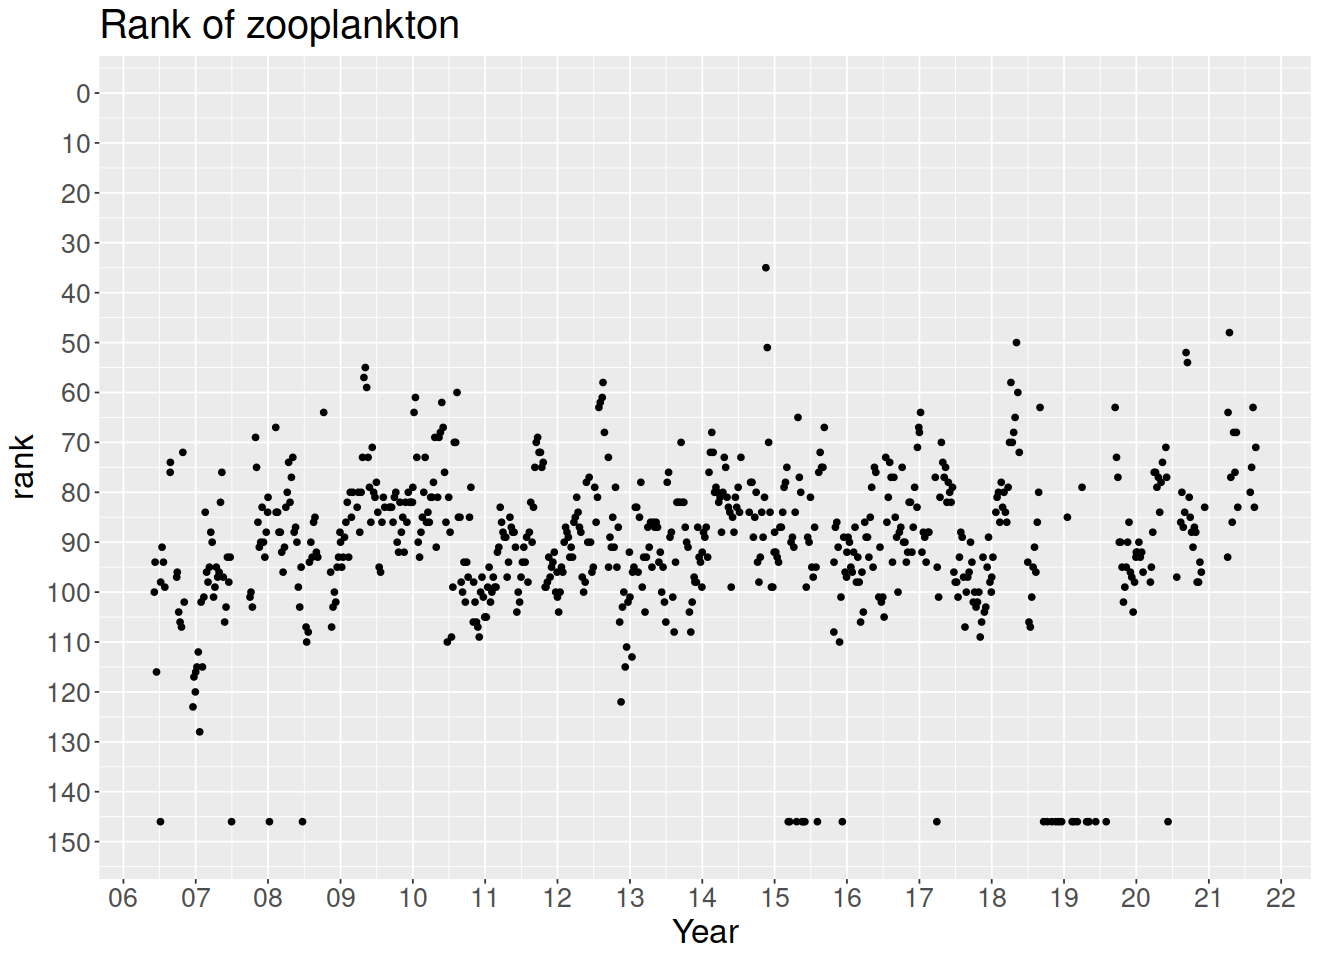

In [5]:
#plotting ONE instance of rank over time for each species
head(df.rank)

result_path = "/D/MIT-WHOI/github_repos/plankton-index/results/weekly_rac_rank/"
cc = which(colnames(df.rank)=="zooplankton")
ggplot(df.rank,aes_string(x= "datetime",y = colnames(df.rank)[cc]))+
      geom_point()+
    ylab("rank")+
    ggtitle(paste0("Rank of ",colnames(df.rank)[cc]))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    xlab("Year")+
     scale_y_reverse(breaks = seq(0, 150, by = 10),limits= c(150,0))+
    theme(text = element_text(size = 20))


In [19]:
#plotting ALL The rank changes of all the species over time
head(df.rank)
result_path = "/D/MIT-WHOI/github_repos/plankton-index/results/weekly_rac_rank/"


for(cc in seq(3,147,1)){
    ggplot(df.rank,aes_string(x= "datetime",y = colnames(df.rank)[cc]))+
          geom_point()+
        ylab("rank")+
        ggtitle(paste0("Rank of ",colnames(df.rank)[cc]))+
        scale_x_date(breaks = "1 year", labels=date_format("%y"))+
        xlab("Year")+
         scale_y_reverse(breaks = seq(0, 150, by = 10),limits= c(150,0))+
        theme(text = element_text(size = 20))
    #saving plot in "rankplot_<species name>_001.png"
    ggsave(paste0(result_path,"rankplot_",colnames(df.rank)[cc],"_",sprintf("%03d", cc),".png"),width = 10,height =8,units = "in",dpi = 500)
    print(paste0(cc-2," of ",ncol(df.rank)-7))
}


,datetime,milliliters_analyzed,Acanthoica_quattrospina,Akashiwo,Alexandrium_catenella,Amphidinium,Amylax,Apedinella,Asterionellopsis_glacialis,Bacillaria,⋯,square_unknown,unknown2,zooplankton,totalcount,year,month,day,my,week,wy
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,2006-06-06,4.063245,34,126,105,101,107,39,54,120,⋯,44,79,100,192573,2006,06,06,2006_06,23,2006_23
2,2006-06-10,10.573908,36,118,133,83,108,58,51,119,⋯,37,106,94,429135,2006,06,10,2006_06,24,2006_24
3,2006-06-17,9.768705,44,127,128,81,93,63,47,129,⋯,32,104,116,333279,2006,06,17,2006_06,25,2006_25
4,2006-07-07,9.818548,40,90,91,92,72,54,37,93,⋯,35,145,146,11965,2006,07,07,2006_07,27,2006_27
5,2006-07-08,10.845375,27,127,121,92,115,52,29,128,⋯,30,77,98,435037,2006,07,08,2006_07,28,2006_28
6,2006-07-15,11.914950,26,130,131,94,107,47,18,132,⋯,28,83,91,328558,2006,07,15,2006_07,29,2006_29


[1] "1 of 148"
[1] "2 of 148"
[1] "3 of 148"
[1] "4 of 148"
[1] "5 of 148"
[1] "6 of 148"
[1] "7 of 148"
[1] "8 of 148"
[1] "9 of 148"
[1] "10 of 148"
[1] "11 of 148"
[1] "12 of 148"
[1] "13 of 148"
[1] "14 of 148"
[1] "15 of 148"
[1] "16 of 148"
[1] "17 of 148"
[1] "18 of 148"
[1] "19 of 148"
[1] "20 of 148"
[1] "21 of 148"
[1] "22 of 148"
[1] "23 of 148"
[1] "24 of 148"
[1] "25 of 148"
[1] "26 of 148"
[1] "27 of 148"
[1] "28 of 148"
[1] "29 of 148"
[1] "30 of 148"
[1] "31 of 148"
[1] "32 of 148"
[1] "33 of 148"
[1] "34 of 148"
[1] "35 of 148"
[1] "36 of 148"
[1] "37 of 148"
[1] "38 of 148"
[1] "39 of 148"
[1] "40 of 148"
[1] "41 of 148"
[1] "42 of 148"
[1] "43 of 148"
[1] "44 of 148"
[1] "45 of 148"
[1] "46 of 148"
[1] "47 of 148"
[1] "48 of 148"
[1] "49 of 148"
[1] "50 of 148"
[1] "51 of 148"
[1] "52 of 148"
[1] "53 of 148"
[1] "54 of 148"
[1] "55 of 148"
[1] "56 of 148"
[1] "57 of 148"
[1] "58 of 148"
[1] "59 of 148"
[1] "60 of 148"
[1] "61 of 148"
[1] "62 of 148"
[1] "63 of 148"
[

In [10]:
library("codyn")

head(df_to_rac)

#convert from wide to long format gather(data,key,value,)
dfc.long <- pivot_longer(df_to_rac,Acanthoica_quattrospina:zooplankton,names_to = "species",values_to ="count",values_drop_na=TRUE)

dfc.long$conc <- dfc.long$count/dfc.long$milliliters_analyzed

head(dfc.long)
# dfrm <- RAC_change(df =dfc.long[complete.cases(dfc.long),], 
#            species.var = "species",
#            abundance.var = "conc",
#            time.var ="datetime")



datetime,milliliters_analyzed,Acanthoica_quattrospina,Akashiwo,Alexandrium_catenella,Amphidinium,Amylax,Apedinella,Asterionellopsis_glacialis,Bacillaria,⋯,square_unknown,unknown2,zooplankton,totalcount,year,month,day,my,week,wy
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
2006-06-06,4.063245,325,1,6,8,5,229,111,2,⋯,178,37,9,192573,2006,06,06,2006_06,23,2006_23
2006-06-10,10.573908,671,2,0,46,9,197,321,2,⋯,651,11,23,429135,2006,06,10,2006_06,24,2006_24
2006-06-17,9.768705,386,0,0,37,20,113,376,0,⋯,739,9,3,333279,2006,06,17,2006_06,25,2006_25
2006-07-07,9.818548,14,0,0,0,1,4,17,0,⋯,25,0,0,11965,2006,07,07,2006_07,27,2006_27
2006-07-08,10.845375,1184,0,1,27,3,262,1078,0,⋯,920,66,18,435037,2006,07,08,2006_07,28,2006_28
2006-07-15,11.914950,1122,0,0,19,7,296,2626,0,⋯,1039,33,22,328558,2006,07,15,2006_07,29,2006_29


datetime,milliliters_analyzed,totalcount,year,month,day,my,week,wy,species,count,conc
<date>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Acanthoica_quattrospina,325,79.9853258
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Akashiwo,1,0.2461087
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Alexandrium_catenella,6,1.4766522
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Amphidinium,8,1.9688696
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Amylax,5,1.2305435
2006-06-06,4.063245,192573,2006,06,06,2006_06,23,2006_23,Apedinella,229,56.3588911


,X,wy,wy2,richness_change,evenness_change,rank_change,gains,losses
,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2006_23,2006_24,-0.014598540,-0.016301598,0.06585327,0.021897810,0.03649635
2,2,2006_24,2006_25,-0.045112782,0.006655278,0.03912036,0.007518797,0.05263158
3,3,2006_25,2006_27,-0.293650794,0.049641090,0.07722348,0.000000000,0.29365079
4,4,2006_27,2006_28,0.293650794,-0.049439379,0.10638700,0.293650794,0.00000000
5,5,2006_28,2006_29,0.022727273,0.002953349,0.04533976,0.045454545,0.02272727
6,6,2006_29,2006_30,-0.007407407,-0.001973684,0.05794239,0.044444444,0.05185185


,X,wy,wy2,richness_change,evenness_change,rank_change,gains,losses,wy.c
,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
1,1,2006_23,2006_24,-0.014598540,-0.016301598,0.06585327,0.021897810,0.03649635,2006-10-04
2,2,2006_24,2006_25,-0.045112782,0.006655278,0.03912036,0.007518797,0.05263158,2006-10-04
3,3,2006_25,2006_27,-0.293650794,0.049641090,0.07722348,0.000000000,0.29365079,2006-10-04
4,4,2006_27,2006_28,0.293650794,-0.049439379,0.10638700,0.293650794,0.00000000,2006-10-04
5,5,2006_28,2006_29,0.022727273,0.002953349,0.04533976,0.045454545,0.02272727,2006-10-04
6,6,2006_29,2006_30,-0.007407407,-0.001973684,0.05794239,0.044444444,0.05185185,2006-10-04


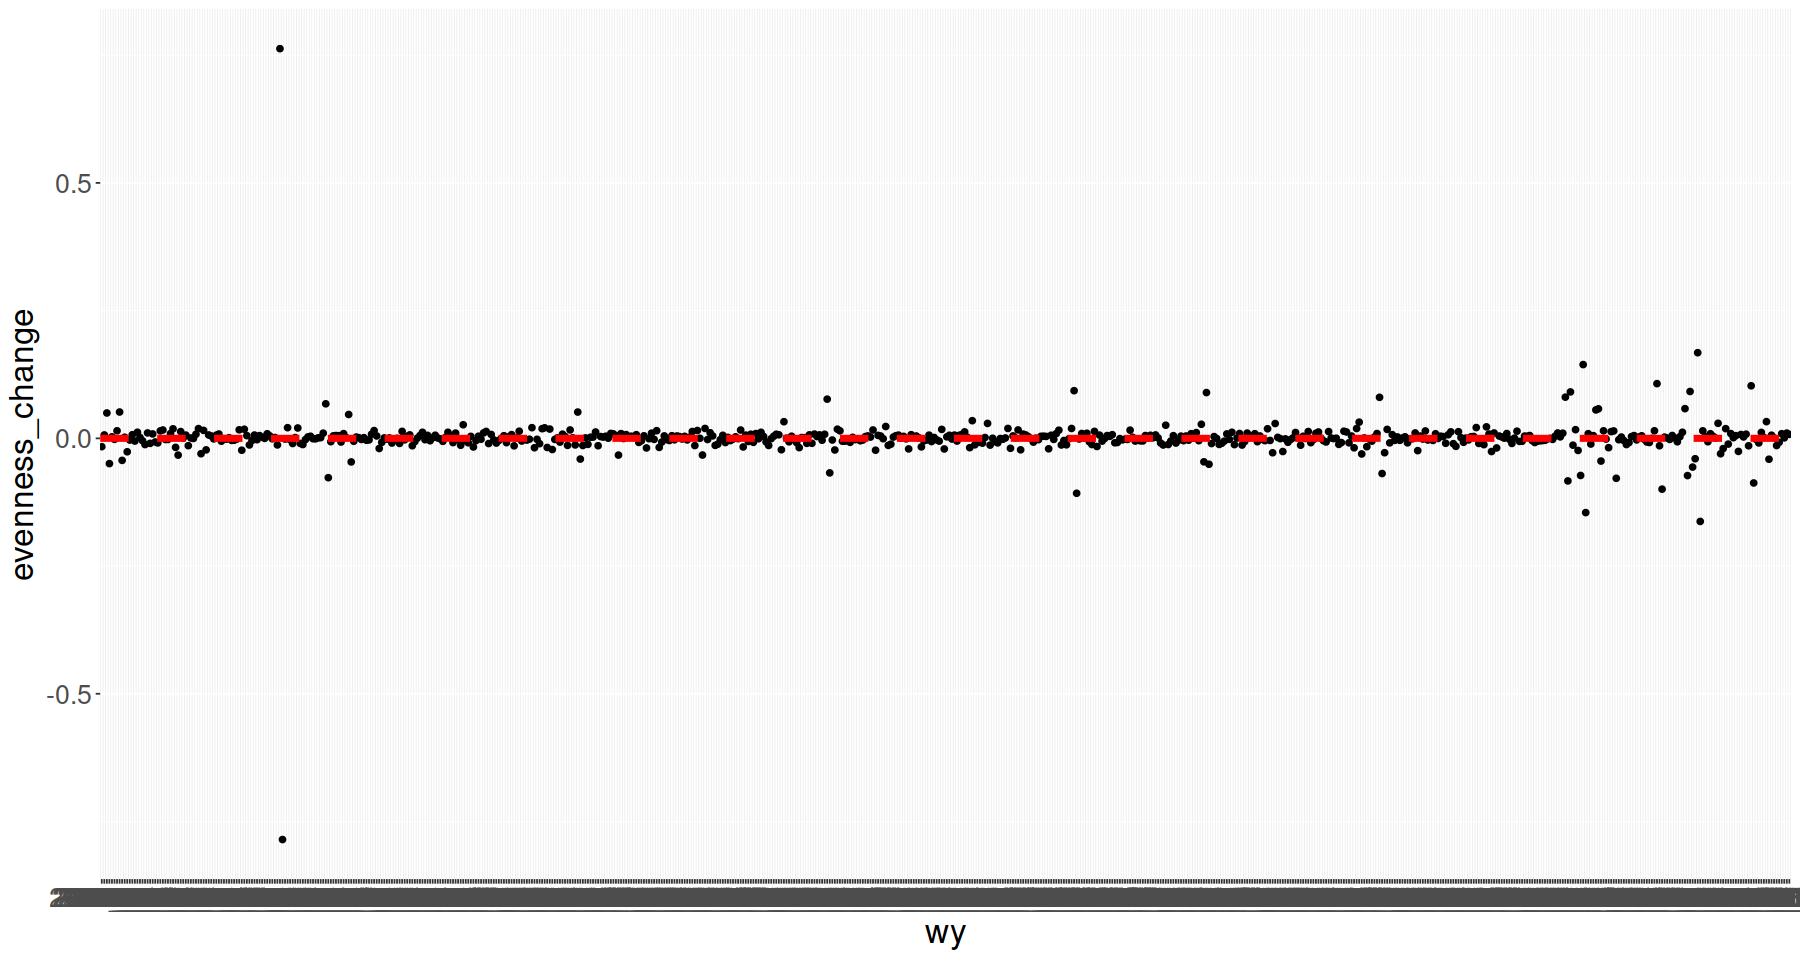

In [20]:
dfrm <- read.csv("/D/MIT-WHOI/github_repos/plankton-index/results/outputRAC_weekly_conc.csv")
head(dfrm)

dfrm$wy.c = as.Date(dfrm$wy,format = "%Y_%w")


head(dfrm)
options(repr.plot.width=15, repr.plot.height=8)


# plotting evenness change
ggplot(data = dfrm,aes(x = wy, y = evenness_change)) +
geom_point()+
geom_hline(yintercept = 0,
           linetype = "dashed",
           color = "red",
           size = 2)+
    theme(text = element_text(size=20))

#   geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)
#     scale_x_date(breaks = "2 year", labels=date_format("%Y"))


# # plotting rank change
# ggplot(data = dfrm,aes(x = wy, y = rank_change)) +
# geom_point()+
#     theme(text = element_text(size=20))
# #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
# #     scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
# ylim(0,0.3)


# # plotting rank change
# ggplot(data = dfrm,aes(x = wy, y = gains)) +
# geom_point()+
#     theme(text = element_text(size=20))
# #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
# #     scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
# # ylim(0,0.3)


# # plotting rank change
# ggplot(data = dfrm,aes(x = wy, y = losses)) +
# geom_point()+
#     theme(text = element_text(size=20))
# #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
# #     scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
# # ylim(0,0.3)

In [ ]:
read.csv(paste0(basepath,))